# Introduction
This is a quick and dirty implementation of a cubic spline interpolation algorithm in python. It was inspired by a use case similar to https://stackoverflow.com/q/28934767/6012085. The new interpolation is not flexible, but performs about 4 times faster than scipy, has a smaller memory overhead, and produces (IMHO) better interpolation results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d as scipy1d
%matplotlib inline

In [2]:
def interp_along_axis(y, x, newx, axis):
    """ Interpolate vertical profiles, e.g. of atmospheric variables
    using vectorized numpy operations

    This function assumes that the x-xoordinate increases
    monotonically and does not extrapolate.

    Peter Kalverla
    March 2018
    
    --------------------
    More info:
    Algorithm from: http://www.paulinternet.nl/?page=bicubic
    It approximates y = f(x) = ax^3 + bx^2 + cx + d
    where y may be an ndarray input vector
    Returns f(newx)

    The algorithm uses the derivative f'(x) = 3ax^2 + 2bx + c
    and uses the fact that:
    f(0) = d
    f(1) = a + b + c + d
    f'(0) = c
    f'(1) = 3a + 2b + c

    Rewriting this yields expressions for a, b, c, d:
    a = 2f(0) - 2f(1) + f'(0) + f'(1)
    b = -3f(0) + 3f(1) - 2f'(0) - f'(1)
    c = f'(0)
    d = f(0)

    These can be evaluated at two neighbouring points in x and
    as such constitute the piecewise cubic interpolator.
    """

    if newx[0]<x[0] or newx[-1]>x[-1]:
        raise ValueError('This function cannot extrapolate')
    if np.any(np.diff(x)<0):
        raise ValueError('x should increase monotonically')

    # View of y with axis as first dimension
    _y = np.moveaxis(y, axis, 0)

    # For now, simply use a numpy function to get the derivatives
    # This produces the largest memory overhead of the function and
    # could alternatively be done in passing.
    ydx = np.gradient(_y)[0]

    # Allocate the output array
    original_dims = _y.shape
    newdims = list(original_dims)
    newdims[0] = len(newx)
    newy = np.zeros(newdims)

    # Loop over new x
    j = 0
    for i,xi in enumerate(newx):
        if xi == x[j]:
            newy[i, ...] = _y[j, ...]
            continue
        if xi == x[j+1]:
            newy[i, ...] = _y[j+1, ...]
            continue

        # Update the bounds if necessary
        within_bounds = lambda xi,j: xi < x[j+1]
        while not within_bounds(xi,j):
            j += 1
            f0, f1 = _y[j], _y[j+1]
            fdx0, fdx1 = ydx[j], ydx[j+1]

            # Determine the parameters of the cubic function
            a = 2*f0 - 2*f1 + fdx0 + fdx1
            b = -3*f0 + 3*f1 - 2*fdx0 - fdx1
            c = fdx0
            d = f0

        xj = (xi-x[j])*(x[j+1]-x[j])  # convert to value between 0 and 1
        newy[i, ...] = a*xj**3 + b*xj**2 + c*xj + d

    return np.moveaxis(newy, 0, axis)

## Testing

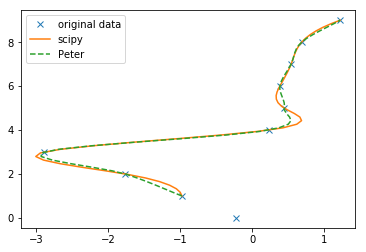

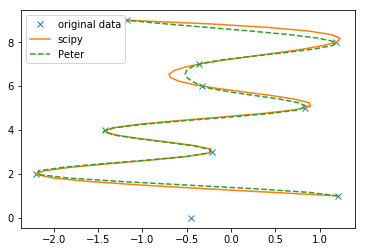

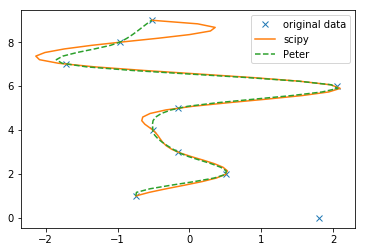

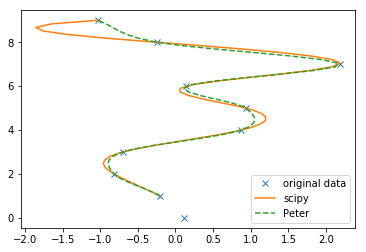

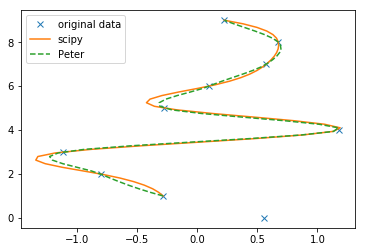

In [4]:
# toy coordinates and data
nx, ny, nz = 25, 30, 10
x = np.arange(nx)
y = np.arange(ny)
z = np.arange(nz)
testdata = np.random.randn(25,30,10) # x,y,z

# Desired z-coordinates (must be between bounds of z)
znew = np.linspace(1,nz-1,50)

# First use scipy interpolation function to check later on
f = scipy1d(z, testdata, axis=2, kind='cubic')
checkdata = f(znew)

# Now use own routine
ynew = interp_along_axis(testdata, z, znew, axis=2)

# Check some random profiles
for i in range(5):
    randx = np.random.randint(nx)
    randy = np.random.randint(ny)

    fig, ax = plt.subplots()
    ax.plot(testdata[randx, randy], z, 'x', label='original data')
    ax.plot(checkdata[randx, randy], znew, label='scipy')
    ax.plot(ynew[randx, randy], znew, '--', label='Peter')
    ax.legend()
    plt.show()

## Time tests

In [7]:
print 'scipy:'
%timeit testdata = np.random.randn(25,30,10); f = scipy1d(z, testdata, axis=2, kind='cubic'); checkdata = f(znew)
%timeit testdata = np.random.randn(250,300,10); f = scipy1d(z, testdata, axis=2, kind='cubic'); checkdata = f(znew)

print '\nnew alogirhtm:'
%timeit testdata = np.random.randn(25,30,10); ynew = interp_along_axis(testdata, z, znew, axis=2)
%timeit testdata = np.random.randn(250,300,10); ynew = interp_along_axis(testdata, z, znew, axis=2)

scipy:
100 loops, best of 3: 5.36 ms per loop
1 loop, best of 3: 455 ms per loop

new alogirhtm:
1000 loops, best of 3: 1.49 ms per loop
10 loops, best of 3: 146 ms per loop


## Memory tests
This doesn't work in the notebook but I print the output below. This should be placed in individual scripts and run from the command line for the cleanest memory report.

In [ ]:
# !pip install memory_profiler
# from memory_profiler import profile

In [ ]:
Scipy performance:

    Line #    Mem usage    Increment   Line Contents
================================================
   115     76.5 MiB     76.5 MiB   @profile
   116                             def scipy_testing():
   117                                 # toy coordinates and data
   118     76.5 MiB      0.0 MiB       nx, ny, nz = 25, 30, 10
   119     76.5 MiB      0.0 MiB       x = np.arange(nx)
   120     76.5 MiB      0.0 MiB       y = np.arange(ny)
   121     76.5 MiB      0.0 MiB       z = np.arange(nz)
   122     82.3 MiB      5.7 MiB       testdata = np.random.randn(250,300,10) # x,y,z
   123
   124                                 # Desired z-coordinates (must be between bounds of z)
   125     82.3 MiB      0.0 MiB       znew = np.linspace(1,nz-1,50)
   126
   127                                 # First use scipy interpolation function to check later on
   128     97.1 MiB     14.8 MiB       f = scipy1d(z, testdata, axis=2, kind='cubic')
   129    125.8 MiB     28.7 MiB       checkdata = f(znew)
   130    125.8 MiB      0.0 MiB       return


In [ ]:
New algorithm performance:

Line #    Mem usage    Increment   Line Contents
================================================
   132     76.5 MiB     76.5 MiB   @profile
   133                             def peter_testing():
   134                                 # toy coordinates and data
   135     76.5 MiB      0.0 MiB       nx, ny, nz = 25, 30, 10
   136     76.5 MiB      0.0 MiB       x = np.arange(nx)
   137     76.5 MiB      0.0 MiB       y = np.arange(ny)
   138     76.5 MiB      0.0 MiB       z = np.arange(nz)
   139     82.3 MiB      5.7 MiB       testdata = np.random.randn(250,300,10) # x,y,z
   140
   141                                 # Desired z-coordinates (must be between bounds of z)
   142     82.3 MiB      0.0 MiB       znew = np.linspace(1,nz-1,50)
   143
   144                                 # Now use own routine
   145    111.9 MiB     29.6 MiB       ynew = interp_along_axis(testdata, z, znew, axis=2)
   146    111.9 MiB      0.0 MiB       return


In [ ]:
Detailed performance report of interp_along_axis

Line #    Mem usage    Increment   Line Contents
================================================
    13     82.3 MiB     82.3 MiB   @profile
    14                             def interp_along_axis(y, x, newx, axis):
    15                                 """ Algorithm from: http://www.paulinternet.nl/?page=bicubic
    16                                 It approximates y = f(x) = ax^3 + bx^2 + cx + d
    17                                 where y may be an ndarray input vector
    18                                 Returns f(newx)
    19
    20                                 The algorithm uses the derivative f'(x) = 3ax^2 + 2bx + c
    21                                 and uses the fact that:
    22                                 f(0) = d
    23                                 f(1) = a + b + c + d
    24                                 f'(0) = c
    25                                 f'(1) = 3a + 2b + c
    26
    27                                 Rewriting this yields expressions for a, b, c, d:
    28                                 a = 2f(0) - 2f(1) + f'(0) + f'(1)
    29                                 b = -3f(0) + 3f(1) - 2f'(0) - f'(1)
    30                                 c = f'(0)
    31                                 d = f(0)
    32
    33                                 These can be evaluated at two neighbouring points in x and
    34                                 as such constitute the piecewise cubic interpolator.
    35
    36                                 This function assumes that the x-xoordinate increases
    37                                 monotonically and does not extrapolate.
    38                                 """
    39     82.3 MiB      0.0 MiB       if newx[0]<x[0] or newx[-1]>x[-1]:
    40                                     raise ValueError('This function cannot extrapolate')
    41     82.3 MiB      0.0 MiB       if np.any(np.diff(x)<0):
    42                                     raise ValueError('x should increase monotonically')
    43
    44                                 # View of y with axis as first dimension
    45     82.3 MiB      0.0 MiB       _y = np.moveaxis(y, axis, 0)
    46
    47                                 # For now, simply use a numpy function to get the derivatives
    48     89.1 MiB      6.9 MiB       ydx = np.gradient(_y)[0]
    49
    50                                 # Allocate the output array
    51     89.1 MiB      0.0 MiB       original_dims = _y.shape
    52     89.1 MiB      0.0 MiB       newdims = list(original_dims)
    53     89.1 MiB      0.0 MiB       newdims[0] = len(newx)
    54     89.1 MiB      0.0 MiB       newy = np.zeros(newdims)
    55
    56                                 # Loop over new x
    57     89.1 MiB      0.0 MiB       j = 0
    58    119.9 MiB      0.0 MiB       for i,xi in enumerate(newx):
    59    119.3 MiB      0.0 MiB           if xi == x[j]:
    60                                         newy[i, ...] = _y[j, ...]
    61                                         continue
    62    119.3 MiB      0.0 MiB           if xi == x[j+1]:
    63    119.9 MiB      1.1 MiB               newy[i, ...] = _y[j+1, ...]
    64    119.9 MiB      0.0 MiB               continue
    65
    66                                     # Update the bounds if necessary
    67    118.8 MiB      0.0 MiB           within_bounds = lambda xi,j: xi < x[j+1]
    68    118.8 MiB      0.0 MiB           while not within_bounds(xi,j):
    69    115.9 MiB      0.0 MiB               j += 1
    70    115.9 MiB      0.0 MiB               f0, f1 = _y[j], _y[j+1]
    71    115.9 MiB      0.0 MiB               fdx0, fdx1 = ydx[j], ydx[j+1]
    72
    73                                         # Determine the parameters of the cubic function
    74    115.9 MiB      0.6 MiB               a = 2*f0 - 2*f1 + fdx0 + fdx1
    75    115.9 MiB      1.0 MiB               b = -3*f0 + 3*f1 - 2*fdx0 - fdx1
    76    115.9 MiB      0.0 MiB               c = fdx0
    77    115.9 MiB      0.0 MiB               d = f0
    78
    79    118.8 MiB      0.0 MiB           xj = (xi-x[j])*(x[j+1]-x[j])  # convert to value between 0 and 1
    80    119.3 MiB     28.0 MiB           newy[i, ...] = a*xj**3 + b*xj**2 + c*xj + d
    81
    82    119.9 MiB      0.0 MiB       return np.moveaxis(newy, 0, axis)


## Conclusions 

Most of the memory increments come from filling the
new array with interpolated values. This makes sense and is unavoidable.
However, the memory overhead from scipy is much larger than from the new
implementation. Finally, this implementation can still be improved by getting
rid of the numpy.gradient call. This can be done as single pass, which reduces
memory overhead by about factor of len(x), where x is the coordinate of the original
data along which the interpolation is performed.

On a side note: the new implementation is about 4 times faster than scipy.